In [1]:
#  博士论文OPLR-TP基于转折点的分段方法 
# 根据不同的数据集和阈值更改对应的参数即可

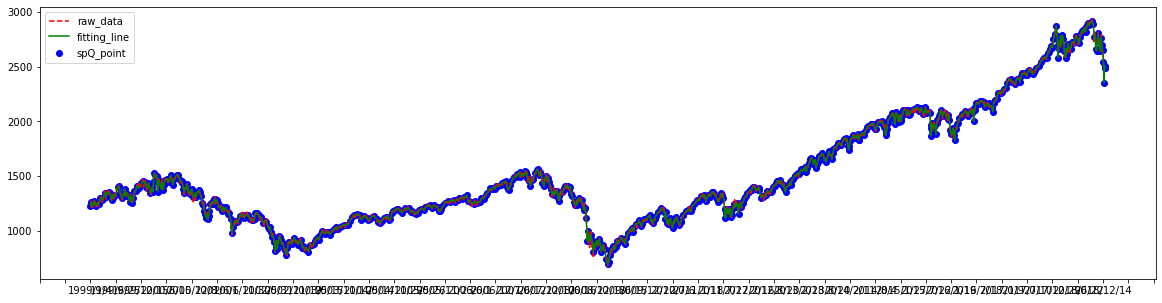

the OPLR-TP mean square fitting error1:  3.608868612589077
the OPLR-TP vertical fitting error2:  91.55418367423087
Running time: 7.514941299999997 Seconds


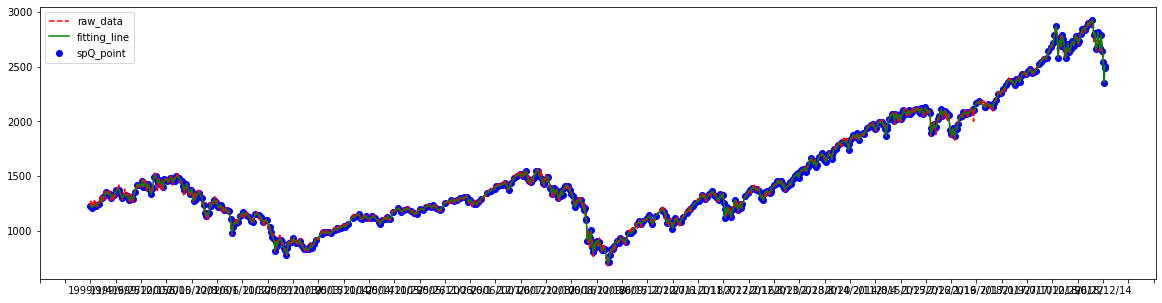

the OPLR-TP mean square fitting error1:  6.254342263992742
the OPLR-TP vertical fitting error2:  126.98313733274875
Running time: 5.271865900000002 Seconds


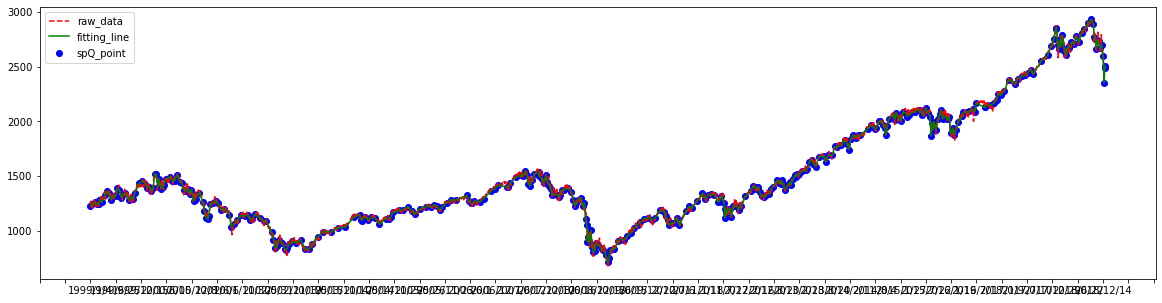

the OPLR-TP mean square fitting error1:  8.236698552806073
the OPLR-TP vertical fitting error2:  149.5714726648246
Running time: 4.468914099999999 Seconds


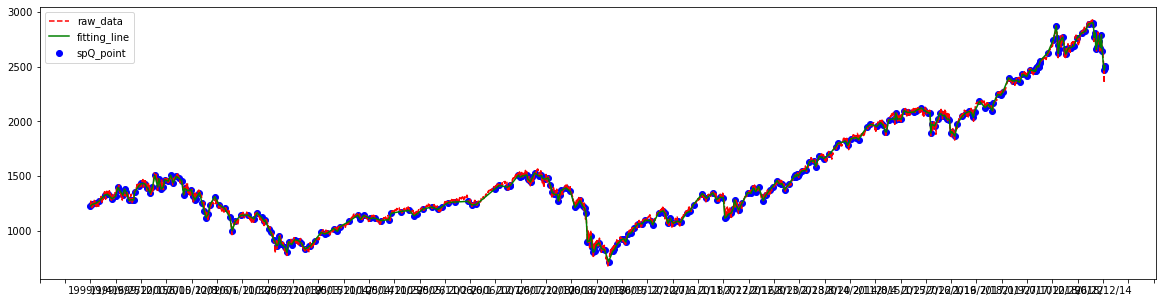

the OPLR-TP mean square fitting error1:  10.14634114678946
the OPLR-TP vertical fitting error2:  171.50605389748782
Running time: 3.717050499999992 Seconds


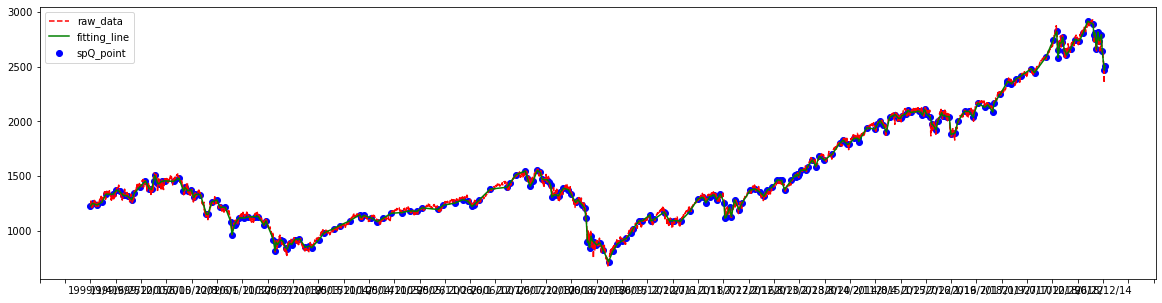

the OPLR-TP mean square fitting error1:  12.674045821063155
the OPLR-TP vertical fitting error2:  193.51914285275902
Running time: 2.927691600000003 Seconds


In [3]:
# -*- coding: utf-8 -*-
# =============================================================================
# """
# Created on Mon Mar  9 14:45:16 2020
# 
# @author: Administrator

# =============================================================================
import numpy as np
import methods as md
import matplotlib.pyplot as plt
import time
import matplotlib.ticker as ticker
seg_num = 10000



def segmentation(TS,X, num, MEP):
    curnum = 0
    tpIList = []
    tpBList = []
    SegList = []
    i = 0 #初始化TS数据的第一个点下标
    sps = TS[i] #将第一个点作为线性分段起始点
    sps_index = 0
    tpIList.append(TS[0]) #线性分段点入栈
    tpBList.append(TS[0])
    SegList.append(sps)

    while curnum <= num:
        Segsup = 9999
        Seglow = -9999 #初始化当先分段斜率上下界为0
        while Segsup >= Seglow and i < len(TS) - 1:
            i += 1
            #print('i=',i)
            if(0<i<len(TS)-1):
                if((TS[i] > TS[i-1] and TS[i] > TS[i+1]) or (TS[i] < TS[i-1] and TS[i] < TS[i+1]) or (TS[i] == TS[i-1] and TS[i] > TS[i+1]) 
                or (TS[i] == TS[i-1] and TS[i] < TS[i+1]) or (TS[i] > TS[i-1] and TS[i] == TS[i+1]) or (TS[i] < TS[i-1] and TS[i] == TS[i+1])):
                    #如果此点是基本转折点，将其进栈，再判断是否为重要转折点
                    tpBList.append(TS[i])
                    #print('转折点i=',i)
                    tpI = tpIList.pop() #取出与TS[i]最近的且在其左侧的重要转折点，用来判断TS[i]是否为重要转折点，判断如下：
                    if(abs(TS[i] - tpI) / ((abs(TS[i]) + abs(tpI)) / 2) >= MEPP):
                        tpIList.append(tpI),tpIList.append(TS[i]) #将出栈的tpI先入栈，再入栈是重要转折点的TS[i]
                    else: #如果当前点不是重要转折点，就将tpI加入到tpIList中，然后将其置为空
                        tpIList.append(tpI)
                        tpI = None
            #Segsup = update_Segsup(TS,X, sps_index ,i)
            Segsup = min(Segsup,((TS[sps_index]-(TS[i] + MEP))/(X[sps_index] - X[i])))
            Seglow = max(Seglow,((TS[sps_index]-(TS[i] - MEP))/(X[sps_index] - X[i])))
            #Seglow = update_Seglow(TS,X, sps_index ,i)#更新上界和下界
        sps_index = i
        sps = TS[i]
        if SegList[-1] != sps:
            SegList.append(sps)
        curnum += 1 #当前分段完毕，进行下一步分段
        #print('当前分段完毕，进行下一步分段!')
    #将原始时间序列的最后一个点加入到分段列表中
    #SegList.append(y[-1])
    return SegList,tpIList,tpBList


#-----------------------计算sps--->spe的分段误差---------------------
def calculate_error(X,Ts):
    #1.获取拟合直线的方程y = a*x + b----这里自变量的量纲问题如何处理，用Ts下的坐标岂不是忽略了它本身的时间序列坐标
    #Ts = Ts.tolist()
    #X = X.tolist()
    #a = abs((Ts[-len(Ts)]-Ts[-1])/len(Ts))
    #b = Ts[-1] - a
    a,b = md.min_error_func(X,Ts)
    sum_error = 0
    for i in range(len(Ts)):
        sum_error += (Ts[i] - (a*X[i] + b))**2
    sum_error = sum_error/len(Ts)
    return sum_error#返回垂直方向的均方误差

#---------------------------参数说明----------------------
#X 为标准化后的时间戳    TS为标准化后的close序列  tpIList, tpBlist都是转折点，MES为误差 , ts 为原始序列用来取数据下标     
def segmentation_1(X,TS,spList, tpIList, tpBList, MES, ts):
    i = 0 #线性分段初始化
    spQ = []#输出的线性分段点队列
    es = 0#计算从sps到spe的分段误差
    
    #---------------函数参数说明----------------
    #1. TS 为原始序列   2. tpIlist,tpBList都是转折点， sps是当前分段起始点， Vtj为当前点的下标
    def findNearestTPI(TS,tpIList,tpBList,sps, Vtj):
        k = 0
        k = TS.index(Vtj)#找到Vtj在原始序列中位置
        while(k < len(TS) - 1):
            k += 1
            if TS[k] in tpIList:#从当前时序点的后面一个点向前找到最近的重要转折点
                return TS[k]        
        return None
    #---------------函数参数说明----------------  
    #1. TS    2. tpIlist,tpBList都是转折点， sps是当前分段起始点， Vtj为当前点的下标
    def findTPBS(TS,tpBList, sps, Vtj):
        k = 0
        k = TS.index(Vtj)
        while(k < len(TS) -1):
            #if (bool(1-(TS[k] in tpIList))):
            if (bool(TS[k + 1] in tpIList) == False):
            #如果找不到重要转折点，则从Vtj向前寻找所有的基础转折点
                if TS[k] in tpBList:
                    cut_point = tpBList.index(TS[k])
                    list_ans = tpBList[cut_point:] #找到Vtj后的所有基础转折点
                    return list_ans
                else:
                    return None
            k += 1

    while(i < len(spList)-1):
        #sps = spList.index(spList[i])#取出当前分段的起止点的下标,sps为起点下标,spe为终点下标
        #spe = spList.index(spList[i + 1])
        sps = y.tolist().index(spList[i])
        spe = y.tolist().index(spList[i + 1])
        spQ.append(spList[i]) #当前分段起始点存入spQ
        j = sps + 1
        #es = 0
        while(j< spe):
            #es += abs(sps - TS[j])
            es += calculate_error(X[sps:spe+1],TS[sps:spe+1])#计算从sps到spe的分段误差,等价于求s到e的单点误差之和,单点误差为两点的MVD最大垂直距离
            if es > MES : #如果当前分段误差超过了预设的分段误差 ，则继续进行分段操作
                #curTPI = findNearestTPI(tpIList, TS[j]) #从Vtj向前寻找最近的重要转折点,
                Vtj = y.tolist()[j]   #Vtj为当前分段的结束点
                curTPI = findNearestTPI(y.tolist(),tpIList,tpBList,sps, Vtj) #从Vtj向前寻找最近的重要转折点
                if curTPI == None:
                    curTPBs = findTPBS(y.tolist(),tpBList, sps, Vtj) #如果找不到TPI则从spList[i]向前寻找所有的基础转折点TPBS
                    if curTPBs == None:
                        #print("555")
                        m = sps
                        while(m < y.tolist().index(Vtj)):
                            if y[m] not in spQ:
                                spQ.append(y[m])
                            m += 1
                        #spBySWAB(sps, spList[i])#在找不到TPBS的最坏情况下，采用SWAB方法的思想获取分段点
                    else:
                        spQ.append(curTPBs[-1]) #全部TPBs作为分段起止点加入spQ
                        #j = curTPBs.getEnd()#重新设置起始点并向后继续进行分段评估
                        #PLR-TP将从离vt；最近的基础转折点，即TPBs的最后一个基础转折点(TPBs．1ength．1)向后继续进行分段评估
                        j = y.tolist().index(curTPBs[-1]) + 1
                else:
                    #spQ.append(curTPBs) #全部TPBs作为分段起止点加入spQ
                    spQ.append(curTPI) #找到离Vtj最近的TPI并将此分段在TPI处进行再次线性分割
                    #j = curTPI.index() #重新设置起始点并向后继续进行分段评估
                    j = y.tolist().index(curTPI) #重新设置起始点并向后继续进行分段评估
            j += 1
        i += 1
    spQ.append(SegList[-1])
    return spQ

def mergeSeg_error(start, end, y, X):
    y_1 = y[y.tolist().index(start): (y.tolist().index(end) + 1)]
    x_1 = X[y.tolist().index(start) : (y.tolist().index(end) + 1)] #找到与ts对应的时间序列x，便于后面分段误差的计算
    k = (y_1[0] - y_1[-1]) / (x_1[0] - x_1[-1])
    b = y_1[0] - k * x_1[0]
    sum_error = 0
    for i in range(len(y_1)):
        sum_error += abs(y_1[i] - (k * x_1[i] + b))
    return sum_error

def mednum_merge(seg_1,MES_merge,y,X_meg):
    start = seg_1[0]
    i = 0
    seg_ans = []
    seg_ans.append(seg_1[0])
    while(i < len(seg_1)-3):
        end = seg_1[i + 2]
        error_1 = mergeSeg_error(start, end,y, X_meg) #计算合并相邻两个分段后的分段误差
        if error_1 < MES_merge:
            #如果加入一个分段点后，满足merge_Error要求，则继续加入分段点
            end = seg_1[seg_1.index(end) + 1]
            
        else:
            seg_ans.append(end)
            start = seg_1[i+1] #不满足合并条件则向后继续合并
        i += 2   
    seg_ans.append(seg_1[-1])
    return seg_ans

def plr_merge(seg_1,MES_merge,y,X_meg):
    start = seg_1[0]
    i = 0
    seg_ans = []
    while(i < len(seg_1)-2):
        end = seg_1[i + 2]
        error_1 = mergeSeg_error(start, end,y, X_meg) #计算合并相邻两个分段后的分段误差
        if error_1 < MES_merge:
            #如果加入一个分段点后，满足merge_Error要求，则合并当前分段
            seg_1[i + 1] = None
            start = end
            
        else:
            start = seg_1[i+1] #不满足合并条件则向后继续合并
        i += 2
    for val in seg_1:
        if val != None:
            seg_ans.append(val)
    return seg_ans
    

if __name__=='__main__':
    MEPP = 0.1#

# =============================================================================
#      TS = loadDataSet(r'C:\Users\Administrator\Desktop\论文\神经网络\test.csv')
#     TS = np.array(TS['Close'])
#     TS_x = loadDataSet(r'C:\Users\Administrator\Desktop\论文\神经网络\test.csv')
#     TS_x = np.array(TS_x['Date'])
#     TS_x = time_translate(TS_x)
#     std_TS_x = np.std(TS_x)#时间序列的原始数据方差
#     mean_TS_x = np.mean(TS_x)#时间序列的原始数据均值
#     x = (TS_x-mean_TS_x)/std_TS_x
# =============================================================================
    #TS = md.loadDataSet(r'E:\论文\论文初写\data\test.csv',encoding='utf-8')
    #TS_x = md.loadDataSet(r'E:\论文\论文初写\data\test.csv',encoding='utf-8')
    TS = md.loadDataSet(r'SAP.csv',encoding='utf-8')
    TS_x = md.loadDataSet(r'SAP.csv',encoding='utf-8')
    ts = np.array(TS_x['Close'])
    ts = ts.tolist()

# =============================================================================
#     ts_volume = np.array(TS_x['Volume'])
#     ts_volume.tolist()
# =============================================================================
    
    ts_x = np.array(TS_x['Date'])
    TS_x = np.array(TS_x['Date'])
    TS_x = md.time_translate(TS_x)
    std_TS_x = np.std(TS_x)#时间序列的原始数据方差
    mean_TS_x = np.mean(TS_x)#时间序列的原始数据均值
    x = (TS_x - mean_TS_x)/std_TS_x #将时间戳x做标准化处理，便于传参进行后续计算
    TS_1 = np.array(TS['Close'])
    #TS_volume = np.array(TS['Volume'])
    #计算 MEPa = (maxv - minv) × MEPP
    #MEP = (max(TS_1.tolist()) - min(TS_1.tolist())) * MEPP
 
    std_TS_1 = np.std(TS_1)#收盘价的原始数据方法
    mean_TS_1 = np.mean(TS_1)#收盘价的原始数据均值
    #y_close = (TS_1 - mean_TS_1)/std_TS_1
    y = (TS_1 - mean_TS_1)/std_TS_1
    
# =============================================================================
#     std_TS_volume = np.std(TS_volume)#交易量的原始数据方法
#     mean_TS_volume = np.mean(TS_volume)#交易量的原始数据均值
#     y_volume = (TS_volume - mean_TS_volume)/std_TS_volume
#     
# =============================================================================
    #y = 0.5 * y_volume + 0.5 * y_close
    
    #MEP = (max(y) - min(y)) * MEPP

    
    spQ=[]
    #定义要存入文件中的结果列表
    list_error = [] #统计误差
    list_segNum=[] #统计分段数
    list_time = [] #运行时间
    list_ans = []
    while(MEPP <=0.5):
        MEPS = 3
        MES = MEPP * MEPS
        MEP = 0.1* MEPP
        #start =time.clock()
        start = time.perf_counter()
        SegList, tpIList, tpBList = segmentation(y,x,seg_num,MEP)
        spQ = segmentation_1(x,y,SegList,tpIList,tpBList,MES,ts)  
        
        #将第二步分段结果恢复原来的时间序列顺序
        spQ_1 = []
        for i in range(len(y)):
            if y[i] in spQ:
                spQ_1.append(y[i])
                
        #最后执行合并操作，得到最终的segList_OPLR
        segList_OPLR = []
        segList_OPLR = spQ_1
        segList_OPLR = plr_merge(spQ_1,MES,y,x)
        
        spQ = []
        spQ = segList_OPLR
        x1 = []
        y1 = []
        for i in range(len(spQ)):
            y1.append(spQ[i])
            x1.append(x[y.tolist().index(y1[i])])
        ans_seg_point_date1=[]
        time_temp=[]
        for i in range(len(spQ)):
            if spQ[i] not in time_temp:
                time_temp.append(ts_x[y.tolist().index(spQ[i])])
        ans_seg_point_date=time_temp
        #segList_OPLR = []
        ans_seg_point_date=[]
    # =============================================================================
    #     for i in range(len(spQ)):
    #         ans_seg_point_date.append(ts_x[ts.index(spQ)])
    # =============================================================================
        #时间序列的复原
    # =============================================================================
    #     for i in range(len(spQ)):
    #         segList_OPLR.append(spQ[i] * std_TS_1 + mean_TS_1)
    # =============================================================================
        for i in range(len(spQ)):
            ans_seg_point_date.append(ts_x[y.tolist().index(spQ[i])])
    
        for i in range(len(spQ)):
            spQ[i] = spQ[i] * std_TS_1 + mean_TS_1
            
        fig = plt.figure(figsize=(20, 5))
        ax = fig.add_subplot(111)
        ax.plot(ts_x,ts,'r--',label='raw_data')
        ax.scatter(ans_seg_point_date,spQ,color='blue',label='spQ_point')
        ax.plot(ans_seg_point_date,spQ,color='green',label='fitting_line')
        tick_spacing = 120
        ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing ))
        ax.legend()
        plt.show()
        error = md.calculate_fitting_error(x1,y1,y,x)
        error2 = md.calculate_vertical_error(x1,y1,y,x)
        print("the OPLR-TP mean square fitting error1: ",error)
        print("the OPLR-TP vertical fitting error2: ",error2)
        end = time.perf_counter()
        #end = time.clock()
        print('Running time: %s Seconds'%(end-start))
        
        
         #将得到结果存入结果列表中
        list_error.append(error2)
        list_segNum.append(len(segList_OPLR))
        list_time.append(end-start)
        MEPP += 0.1
    list_ans.append(list_error)
    list_ans.append(list_segNum)
    list_ans.append(list_time)    
    np.savetxt('output/SAPO/SAPO_OPLR_TP.txt',list_ans,fmt='%.4f')  
    
   
    